# GWAS-tutorial
This tutorial will cover the main steps for the quality control before GWAS.

### GWAS in 5 steps
1. [sexcheck](#sexcheck)
2. [QC](#QC)
3. [relatedness check](#relatedness)
4. [PCA](#PCA)
5. [Association analysis](#glm)

First we will simulate genotyping data to work with. For that, we will use a template from the [Illumina GSA](https://www.illumina.com/products/by-type/microarray-kits/infinium-global-screening.html) chip. We will create ~ 600 significant associations on chromosome 22.

In [2]:
# declaring variables
bfile="GSA_sim"
GSA_bim="data/GSA.bim"
n_lines_bim=$(wc -l < ${GSA_bim})
n_assoc=600
n_tail=22000

n_lines_bim_noassoc=$(echo ${n_lines_bim} - ${n_assoc} - ${n_tail} | bc)
echo "${n_lines_bim_noassoc} null_A 0.00 1.00 1.00 1.00
${n_assoc} disease 0.00 1.00 4.00 mult
${n_tail} null_B 0.00 1.00 1.00 1.00" > wgas.sim
./plink --simulate wgas.sim \
--simulate-ncases 50 --simulate-ncontrols 50 \
--make-bed --out ${bfile}

./plink --bfile ${bfile} \
--update-chr <(paste <(awk '{print $2}' ${bfile}.bim) \
<(awk '{print $1}' ${GSA_bim})) \
--update-map <(paste <(awk '{print $2}' ${bfile}.bim) \
<(awk '{print $4}' ${GSA_bim})) \
--make-bed --out ${bfile}_chr_temp

paste <(awk '{print $2}' ${bfile}.bim) \
<(awk '{print $2}' ${GSA_bim}) > ${bfile}_id_temp

./plink --bfile ${bfile}_chr_temp \
--update-name ${bfile}_id_temp \
--make-bed --out ${bfile}_chr_id_temp

./plink --bfile ${bfile}_chr_id_temp \
--exclude <(awk '{print $2}' ${bfile}_chr_id_temp.bim | sort | uniq -c | awk '{if ($1 > 1) print $2}') \
--make-bed --out ${bfile}_chr_id_temp_nodup

awk: cannot open GSA_sim_chr_id_temp.bim (No such file or directory)
PLINK v1.90b6.17 64-bit (28 Apr 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to GSA_sim.log.
Options in effect:
  --make-bed
  --out GSA_sim
  --simulate wgas.sim
  --simulate-ncases 50
  --simulate-ncontrols 50

15877 MB RAM detected; reserving 7938 MB for main workspace.
Writing --simulate dataset to GSA_sim-temporary.bed + GSA_sim-temporary.bim +
GSA_sim-temporary.fam ... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%71%72%73%74%75%76%77%78%79%80%

In [3]:
library(data.table)
bfile="GSA_sim_chr_id_temp_nodup.bim"
GSA_bim="data/GSA.bim"
sim=fread(bfile)
gsa=fread(GSA_bim)
gsa=gsa[V2 %in% sim[[2]]]
gsa_sim=merge(gsa, sim, by='V2')
gsa_sim=gsa_sim[match(sim[[2]],gsa_sim[[1]])]
fwrite(gsa_sim[,c(1,10,11,5,6)], paste0(bfile, '_updids'), sep=' ', col.names=F, na=NA, quote=F)


In [4]:
bfile="GSA_sim"
./plink --bfile ${bfile}_chr_id_temp_nodup \
--update-alleles ${bfile}_chr_id_temp_nodup.bim_updids \
--make-bed --out ${bfile}
rm ${bfile}*temp*

PLINK v1.90b6.17 64-bit (28 Apr 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to GSA_sim.log.
Options in effect:
  --bfile GSA_sim_chr_id_temp_nodup
  --make-bed
  --out GSA_sim
  --update-alleles GSA_sim_chr_id_temp_nodup.bim_updids

15877 MB RAM detected; reserving 7938 MB for main workspace.
604871 variants loaded from .bim file.
100 people (0 males, 100 females) loaded from .fam.
100 phenotype values loaded from .fam.
--update-alleles: 604871 variants updated.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 100 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%

### sexcheck

In [5]:
# checking sex of samples using X-chromosome
bfile="GSA_sim"
./plink2 --bfile ${bfile} --chr 23 --indep-pairwise 1000 50 0.2 --out ${bfile}_pruning
./plink2 --bfile ${bfile} --extract <(cat ${bfile}_pruning.prune.in) \
--make-bed --out ${bfile}_pruning
./plink --bfile ${bfile}_pruning --check-sex --out ${bfile}_sexcheck
rm ${bfile}_pruning*


PLINK v2.00a2.3LM 64-bit Intel (24 Jan 2020)   www.cog-genomics.org/plink/2.0/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to GSA_sim_pruning.log.
Options in effect:
  --bfile GSA_sim
  --chr 23
  --indep-pairwise 1000 50 0.2
  --out GSA_sim_pruning

Start time: Sun May 31 16:01:18 2020
15877 MiB RAM detected; reserving 7938 MiB for main workspace.
Using up to 4 compute threads.
100 samples (100 females, 0 males; 100 founders) loaded from GSA_sim.fam.
15570 out of 604871 variants loaded from GSA_sim.bim.
1 binary phenotype loaded (50 cases, 50 controls).
Calculating allele frequencies... 0%13%done.
--indep-pairwise (1 compute thread): 0%50%695/15570 variants removed.
Variant lists written to GSA_sim_pruning.prune.in and GSA_sim_pruning.prune.out
.
End time: Sun May 31 16:01:19 2020
PLINK v2.00a2.3LM 64-bit Intel (24 Jan 2020)   www.cog-genomics.org/plink/2.0/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License

Empty data.table (0 rows and 6 cols): FID,IID,PEDSEX,SNPSEX,STATUS,F


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



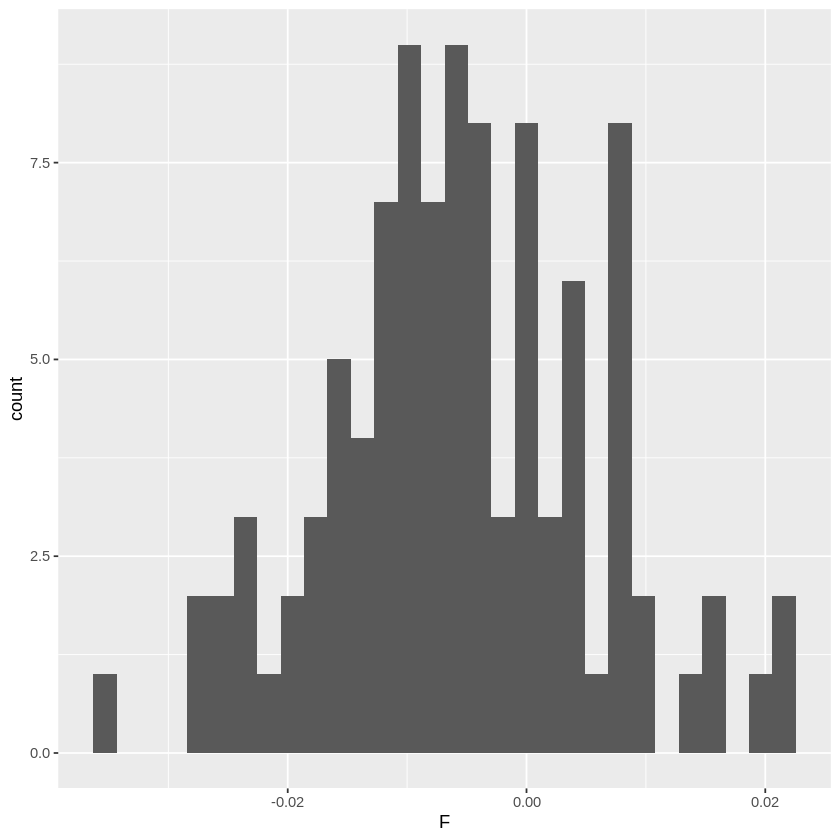

In [12]:
library(data.table)
library(ggplot2)
# listing samples with incorrect sex assignment
bfile="GSA_sim"
bfile=fread(paste0(bfile, "_sexcheck.sexcheck"))
print(bfile[STATUS != "OK"])
ggplot(bfile, aes(x=F)) +
    geom_histogram()

In [13]:
# If any samples had incorrect sex,
# this command can update sex and remove samples where sex was not determined
bfile="GSA_sim"
./plink --bfile ${bfile} \
--update-sex <(awk '{if ($5 == "PROBLEM") print $1,$2,$4}' ${bfile}_sexcheck.sexcheck) \
--remove <(awk '{if ($4 == 0) print $1,$2}' ${bfile}_sexcheck.sexcheck) \
--make-bed --out ${bfile}_checkedsex


PLINK v1.90b6.17 64-bit (28 Apr 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to GSA_sim_checkedsex.log.
Options in effect:
  --bfile GSA_sim
  --make-bed
  --out GSA_sim_checkedsex
  --remove /dev/fd/62
  --update-sex /dev/fd/63

15877 MB RAM detected; reserving 7938 MB for main workspace.
604871 variants loaded from .bim file.
100 people (0 males, 100 females) loaded from .fam.
100 phenotype values loaded from .fam.
--update-sex: 0 people updated.
--remove: 100 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 100 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%

### QC

In [17]:
# MAF 1%
# missingness per variant 2% 
# missingness per sample 2% 
# HWE test p < 1e-10
bfile="GSA_sim_checkedsex"
maf_set=0.01
geno_set=0.02
mind_set=0.02
echo $bfile $maf_set $geno_set $mind_set
./plink2 --bfile ${bfile} \
--maf ${maf_set} \
--geno 0.2 \
--hwe 1e-6 \
--allow-no-sex \
--make-bed --out ${bfile}_geno02
./plink2 --bfile ${bfile}_geno02 \
--hwe 1e-10 \
--mind 0.2 \
--allow-no-sex \
--make-bed --out ${bfile}_geno02_mind02
./plink2 --bfile ${bfile}_geno02_mind02 \
--geno ${geno_set} \
--allow-no-sex \
--make-bed --out ${bfile}_geno02_mind02_geno002
./plink2 --bfile ${bfile}_geno02_mind02_geno002 \
--mind ${mind_set} \
--allow-no-sex \
--make-bed --out ${bfile}_geno02_mind02_geno002_mind002

GSA_sim_checkedsex 0.01 0.02 0.02
PLINK v2.00a2.3LM 64-bit Intel (24 Jan 2020)   www.cog-genomics.org/plink/2.0/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to GSA_sim_checkedsex_geno02.log.
Options in effect:
  --allow-no-sex
  --bfile GSA_sim_checkedsex
  --geno 0.2
  --hwe 1e-6
  --maf 0.01
  --make-bed
  --out GSA_sim_checkedsex_geno02

Start time: Sun May 31 16:09:15 2020
Note: --allow-no-sex no longer has any effect.  (Missing-sex samples are
automatically excluded from association analysis when sex is a covariate, and
treated normally otherwise.)
15877 MiB RAM detected; reserving 7938 MiB for main workspace.
Using up to 4 compute threads.
100 samples (100 females, 0 males; 100 founders) loaded from
GSA_sim_checkedsex.fam.
604871 variants loaded from GSA_sim_checkedsex.bim.
1 binary phenotype loaded (50 cases, 50 controls).
Calculating allele frequencies... 0%10%21%32%43%54%65%75%86%97%done.
--geno: 0 variant

### relatedness

In [18]:
bfile="GSA_sim_checkedsex_geno02_mind02_geno002_mind002"
./king -b ${bfile}.bed \
--related \
--degree 3 \
--prefix ${bfile} \
--cpus 4

KING 2.2.4 - (c) 2010-2019 Wei-Min Chen

The following parameters are in effect:
                   Binary File : GSA_sim_checkedsex_geno02_mind02_geno002_mind002.bed (-bname)

Additional Options
         Close Relative Inference : --related [ON], --duplicate
   Pairwise Relatedness Inference : --kinship, --ibdseg, --ibs, --homog
              Inference Parameter : --degree [3]
         Relationship Application : --unrelated, --cluster, --build
                        QC Report : --bysample, --bySNP, --roh, --autoQC
                     QC Parameter : --callrateN, --callrateM
             Population Structure : --pca, --mds
              Structure Parameter : --projection, --pcs
              Disease Association : --tdt
   Quantitative Trait Association : --mtscore
                Association Model : --trait [], --covariate []
            Association Parameter : --invnorm, --maxP
               Genetic Risk Score : --risk, --model [], --prevalence, --noflip
              Computing Para

In [19]:
# If any relatives were detected, the following command will remove them
bfile="GSA_sim_checkedsex_geno02_mind02_geno002_mind002"
./plink2 --bfile ${bfile} \
--remove <(awk '{print $1,$2}' ${bfile}.kin0 | tail -n +2) \
--make-bed --out ${bfile}_norelated
echo "Removed sample(s):"
awk '{print $1,$2}' ${bfile}.kin0 | tail -n +2


PLINK v2.00a2.3LM 64-bit Intel (24 Jan 2020)   www.cog-genomics.org/plink/2.0/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated.log.
Options in effect:
  --bfile GSA_sim_checkedsex_geno02_mind02_geno002_mind002
  --make-bed
  --out GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated
  --remove /dev/fd/63

Start time: Sun May 31 16:09:22 2020
15877 MiB RAM detected; reserving 7938 MiB for main workspace.
Using up to 4 compute threads.
100 samples (100 females, 0 males; 100 founders) loaded from
GSA_sim_checkedsex_geno02_mind02_geno002_mind002.fam.
awk: cannot open GSA_sim_checkedsex_geno02_mind02_geno002_mind002.kin0 (No such file or directory)
592851 variants loaded from
GSA_sim_checkedsex_geno02_mind02_geno002_mind002.bim.
1 binary phenotype loaded (50 cases, 50 controls).
--remove: 100 samples remaining.
100 samples (100 females, 0 males; 100 founders) remaining after main filte

### PCA

In [20]:
bfile="GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated"
./plink2 --bfile ${bfile} \
--indep-pairwise 1000 50 0.2 \
--out ${bfile}_pruned
./plink2 --bfile ${bfile} \
--extract <(cat ${bfile}_pruned.prune.in) \
--pca --out ${bfile}_eigen
rm ${bfile}*prun*

PLINK v2.00a2.3LM 64-bit Intel (24 Jan 2020)   www.cog-genomics.org/plink/2.0/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated_pruned.log.
Options in effect:
  --bfile GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated
  --indep-pairwise 1000 50 0.2
  --out GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated_pruned

Start time: Sun May 31 16:09:24 2020
15877 MiB RAM detected; reserving 7938 MiB for main workspace.
Using up to 4 compute threads.
100 samples (100 females, 0 males; 100 founders) loaded from
GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated.fam.
592851 variants loaded from
GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated.bim.
1 binary phenotype loaded (50 cases, 50 controls).
Calculating allele frequencies... 0%11%22%33%44%55%66%77%88%99%done.
--indep-pairwise (3 compute threads): 0%32%65%98%16182/592

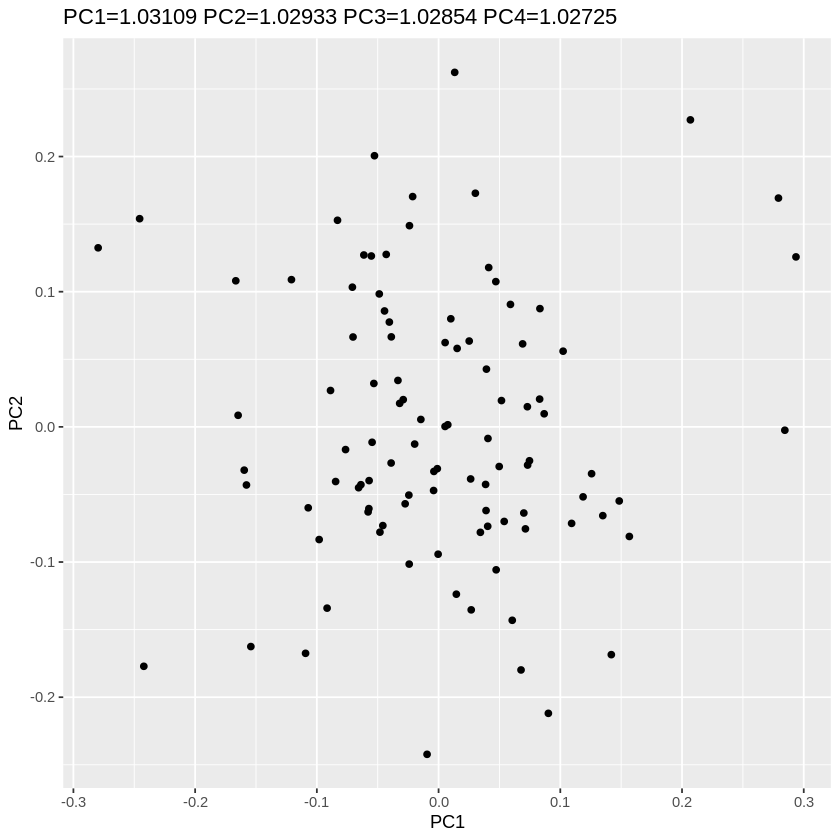

In [21]:
library(data.table)
bfile="GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated"
eigenvec=fread(paste0(bfile, "_eigen.eigenvec"))
eigenval=fread(paste0(bfile, "_eigen.eigenval"), header=F)
p_all=ggplot(eigenvec, aes(x=PC1, y=PC2)) +
geom_point() +
ggtitle(paste0("PC1=", eigenval[1], " PC2=", eigenval[2], " PC3=", eigenval[3], " PC4=", eigenval[4]))
print(p_all)


### GLM
association testing

In [22]:
bfile="GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated"
./plink2 --bfile ${bfile} \
--glm hide-covar \
--covar ${bfile}_eigen.eigenvec \
--covar-name PC1, PC2, PC3, PC4 \
--out ${bfile}


PLINK v2.00a2.3LM 64-bit Intel (24 Jan 2020)   www.cog-genomics.org/plink/2.0/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated.log.
Options in effect:
  --bfile GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated
  --covar GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated_eigen.eigenvec
  --covar-name PC1, PC2, PC3, PC4
  --glm hide-covar
  --out GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated

Start time: Sun May 31 16:09:42 2020
15877 MiB RAM detected; reserving 7938 MiB for main workspace.
Using up to 4 compute threads.
100 samples (100 females, 0 males; 100 founders) loaded from
GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated.fam.
592851 variants loaded from
GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated.bim.
1 binary phenotype loaded (50 cases, 50 controls).
4 covariates loaded from GSA_sim_checkedsex_geno02_mind02_geno002_mind002_n

In [23]:
library(data.table)
glmfile="GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated.PHENO1.glm.logistic"
lapply(c("qqman"), require, character.only = TRUE)
assoc_pc=fread(glmfile)
assoc_pc[`#CHROM` == "X", `#CHROM` := "23"]
assoc_pc=assoc_pc[, `#CHROM` := as.numeric(`#CHROM`)][!is.na(P) & !is.na(`#CHROM`)]
# producing Manhattan plot
jpeg(paste0(glmfile, "_manh.jpeg"), width = 12, height = 6, units = "in", res = 300)
print(manhattan(rbind(assoc_pc[P<5e-2], assoc_pc[P>5e-2][seq(1,nrow(assoc_pc[P>5e-2]),10)]), chr="#CHROM", bp="POS", p="P", snp="ID", annotatePval = 1, annotateTop = T, col=palette()))
dev.off()
# producing Q-Q plot
jpeg(paste0(glmfile, "_qq.jpeg"), width = 6, height = 6, units = "in", res = 300)
print(qq(assoc_pc$P))
dev.off()


Loading required package: qqman



For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, S.D. qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. biorXiv DOI: 10.1101/005165 (2014).





[[1]]
[1] TRUE

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”


$xpd
[1] TRUE



png 
  2

NULL


png 
  2

![manh](GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated.PHENO1.glm.logistic_manh.jpeg)

![qq](GSA_sim_checkedsex_geno02_mind02_geno002_mind002_norelated.PHENO1.glm.logistic_qq.jpeg)